<a href="https://colab.research.google.com/github/zoetice/data-science/blob/main/Zoe_TiceU4proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 4 Project
**What is the average number of points a scoring player in the NFL makes in a season?**

**Context**

The National Football League is the United State's main professional football league. In American Football, points can be scored in 4 ways: a touchdown (6 points), a field goal (3 points), a field kick (1 point), and a safety (2 points).

**Data:**
My data is of the points scored during the 2024 season. It comes from the website "Pro Football Reference". It is seperated by team and points, listing each scoring players name and the amount of points they scored in the season.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import graphviz as gv
import pymc as pm

In [2]:
url_nfl = 'https://raw.githubusercontent.com/zoetice/data-science/refs/heads/main/unit%204%20stats%20-%20Sheet1%20(1).csv'
#I could have put the url string directly into pd.read_csv()
nfl_data = pd.read_csv(url_nfl)

In [40]:
nfl_data

,Player,Team,Position,points
0,Trey Benson,AC,RB,6
1,Michael Carter,AC,RB,6
2,Emari Demercado,AC,RB,6
3,Tony Jones,AC,RB,6
4,Jonah Williams,AC,OL,6
...,...,...,...,...
451,Jayden Daniels,WC,QB,38
452,Zach Ertz,WC,TE,46
453,Brian Robinson Jr.,WC,RB,48
454,Terry McLaurin,WC,WR,78


from matplotlib import pyplot as plt
nfl_data['points'].plot(kind='hist', bins=20, title='points')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
nfl_data['points'].plot(kind='line', figsize=(8, 4), title='points')
plt.gca().spines[['top', 'right']].set_visible(False)

In [4]:
nfl_data['Position'] = nfl_data['Position'].astype('category')
pos_idx = nfl_data.Position.cat.codes.values

In [5]:
pos_codes = nfl_data.Position.cat.categories

In [6]:
nfl_coords = {"pos": pos_codes}

<Axes: ylabel='points'>

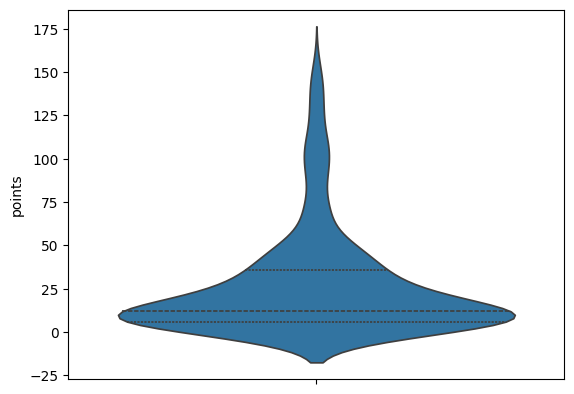

In [7]:
sns.violinplot(nfl_data.points,inner='quart')

**Priors:**

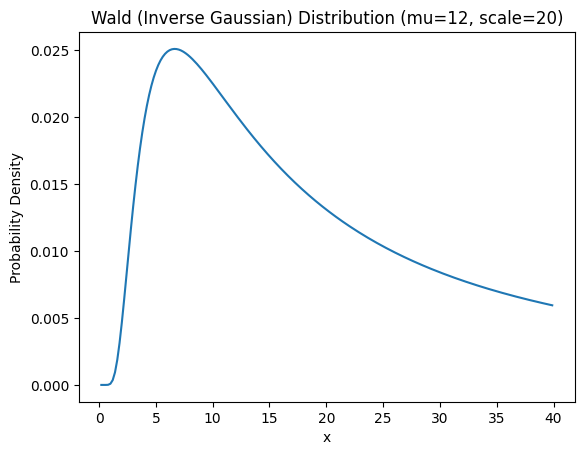

In [9]:
from scipy.stats import invgauss
import numpy as np
import matplotlib.pyplot as plt

# Define the parameters for the Wald (Inverse Gaussian) distribution
# scipy.stats uses mu and scale (lambda in pymc)
mu = 12
scale = 20 # Corresponds to lambda in PyMC's Wald

# Create a range of x values (Wald is for positive values)
# We can use the mean and variance (mu^3 / scale) to determine a reasonable range
variance = mu**3 / scale
std_dev = np.sqrt(variance)
x = np.linspace(0, mu + 3 * std_dev, 200)
x = x[x > 0] # Ensure x values are positive

# Calculate the PDF for the given x values
pdf_values = invgauss.pdf(x, mu, scale=scale)

# Plot the PDF
plt.plot(x, pdf_values)
plt.title(f'Wald (Inverse Gaussian) Distribution (mu={mu}, scale={scale})')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.show()

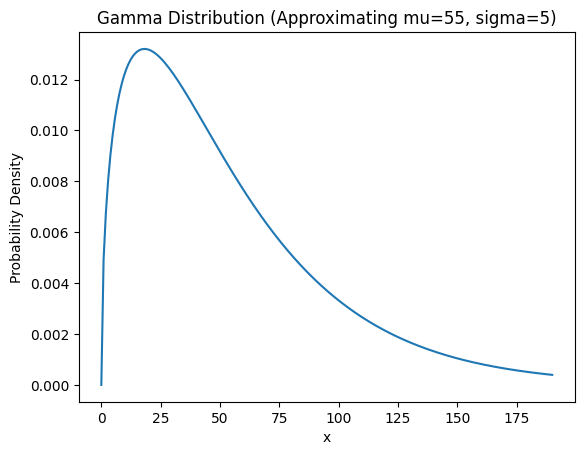

In [8]:
from scipy.stats import gamma
import numpy as np
import matplotlib.pyplot as plt

# Define the parameters for the Gamma distribution (using shape and scale)
# Approximating mean=55, std=45
shape = (55/45)**2 # k = (mean/std)**2
scale = 45**2/55  # theta = std**2/mean

# Create a range of x values
x = np.linspace(0, shape * scale + 3 * np.sqrt(shape * scale**2), 200) # Extend x to cover most of the distribution

# Calculate the PDF for the given x values
pdf_values = gamma.pdf(x, a=shape, scale=scale) # 'a' is the shape parameter in scipy.stats

# Plot the PDF
plt.plot(x, pdf_values)
plt.title(f'Gamma Distribution (Approximating mu=55, sigma=5)')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.show()

**Hierarchical**

I've done my Hierarchical based on players' positions. Since 2/4 of the ways to score have the kicker scoring, I would assume that they lead the pack in highest scorers.

In [ ]:
with pm.Model(coords=nfl_coords) as nfl_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Wald('μ_mu', mu = 12, lam = 20)
    μ_sd = pm.Gamma('μ_sd', mu = 55, sigma = 5)


    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    # Corrected: Changed 'Position' to 'pos' in dims
    μ = pm.Wald('μ',
                  mu = μ_mu, # I include the hyperprior in my prior
                  lam = μ_sd, # I include the hyperprior in my prior
                  dims = "pos")

    # Corrected: Changed 'Position' to 'pos' in dims
    σ = pm.Gamma('σ', mu = 55, sigma = 5,
                      dims = "pos")

    #likelihood; same as before
    # Corrected: Changed observed variable name to 'points' and removed non-existent 'diff_TminusE'
    # Note: A Normal likelihood might not be appropriate for count data like points.
    y = pm.InverseGamma('points',
                  alpha = μ[pos_idx], #I include the prior in my likelihood
                  beta = σ[pos_idx], #I include the prior in my likelihood
                  observed = nfl_data.points.values)

    #cs for chemshift, h for heirarchical
    idata_nfl_h = pm.sample(posterior_predictive=True)

array([<Axes: >], dtype=object)

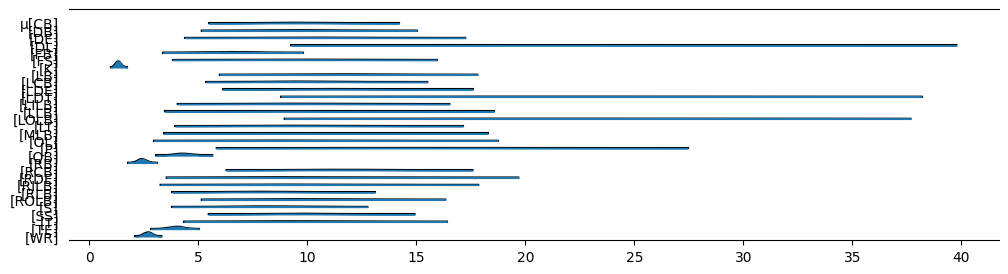

In [26]:

az.plot_forest(idata_nfl_h, var_names=['μ'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

In [ ]:
with nfl_h_model:
  pm.sample_posterior_predictive(idata_nfl_h, extend_inferencedata=True)

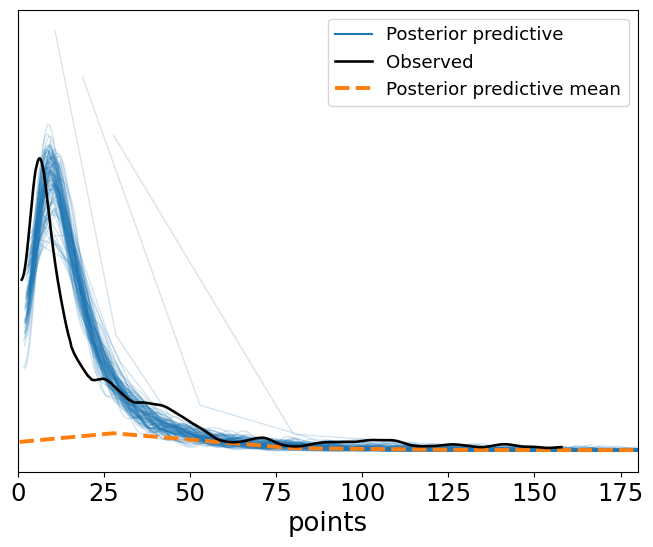

In [42]:
fig,ax=plt.subplots(figsize=(8,6))
az.plot_ppc(idata_nfl_h, num_pp_samples=100, ax=ax, figsize=(12,4))
ax.set_xlim(0,180)
plt.show()

**Non-Hierarchical**

This one will not be based on hyperpriors

In [ ]:
with pm.Model(coords=nfl_coords) as nfl_nh_model:
    #priors
    μ = pm.Wald('μ', mu=12, lam=20,
                  dims="pos")
    σ = pm.Gamma('σ', mu=55, sigma=5,
                      dims="pos")

    #The idx variable tells my model which diffs belong to the same amino acid
    #this will cause my model to generate a posterior for each amino acid
    y = pm.InverseGamma('y',
                  alpha = μ[pos_idx],
                  beta = σ[pos_idx],
                  observed=nfl_data.points.values)

    #cs for chemshift, nh for nonheirarchical
    idata_nfl_nh = pm.sample()

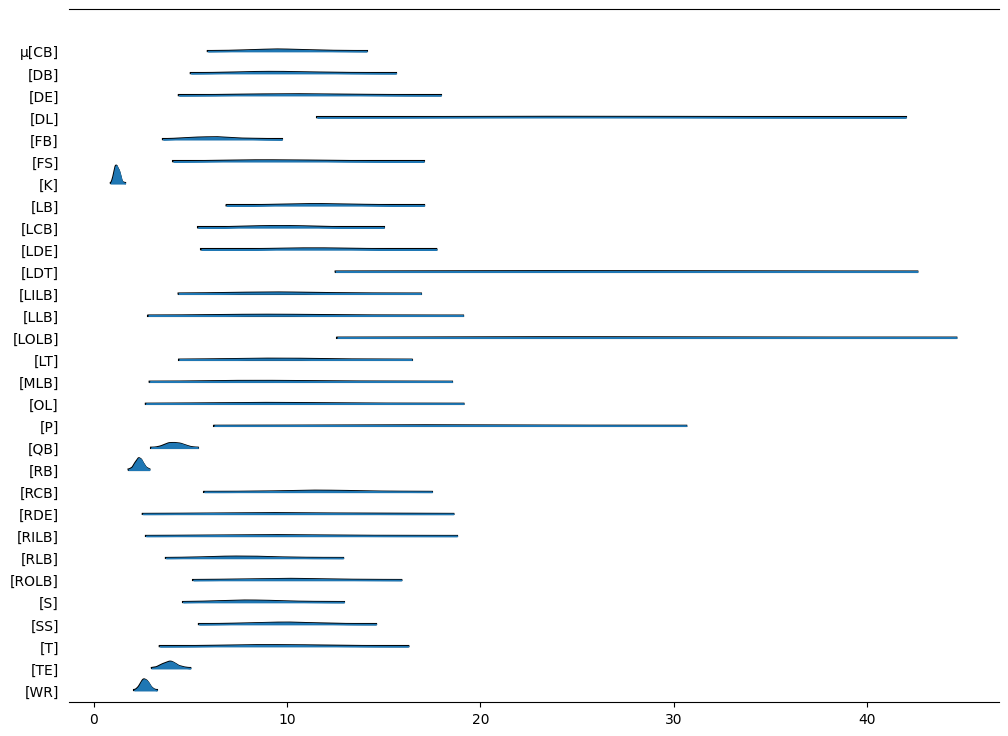

In [36]:
axes = az.plot_forest(idata_nfl_nh, kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

In [ ]:
with nfl_nh_model:
  pm.sample_posterior_predictive(idata_nfl_nh, extend_inferencedata=True)

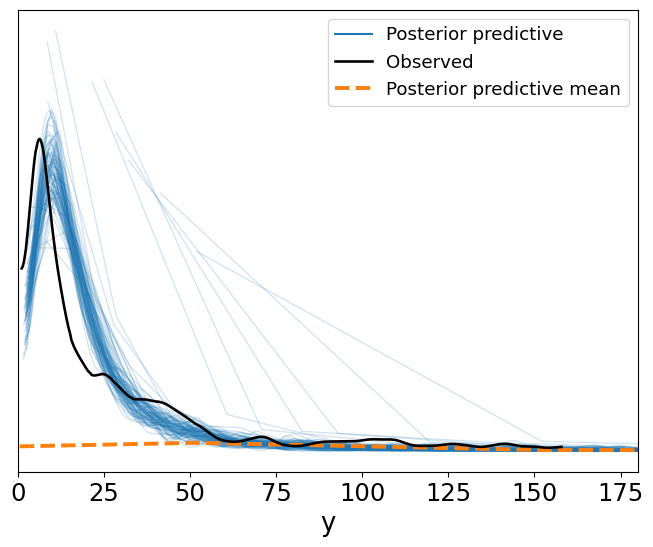

In [44]:

fig,ax=plt.subplots(figsize=(8,6))
az.plot_ppc(idata_nfl_nh, num_pp_samples=100, ax=ax, figsize=(12,4))
ax.set_xlim(0,180)
plt.show()

**Conclusion**

Although very close, I would say the Hierarchical works better. Taking positions into account more with hyperpriors helps organise that information better.

**Is This Accurate?**

*Maybe*... The way that the NFL works sees some teams play more games than others (if they advance), so a kicker from the Eagles *may* score more points in a season than a kicker from the Browns simply because they played more games. This inconsistancy would throw of the average if you were looking for every person to have the same chance to score goals. Going forward I could try again one of two ways: Only take data from games before elimination rounds or try to find the average of a game in the NFL, not a season. Given that the latter would require an average on top of an average, I would most likely go with the former. That being said certain players having more chances to score is accurate with how the NFL works, so you don't nessasarily have to change that.